<p> Notice: This notebook is not optimized for memory nor performance yet. Please use it with caution when handling large datasets.


### Notice: Please ignore Feature engineering part if you are using a ready dataset

# Feature engineering

This notebook is for BDSE12_03G_HomeCredit_V2.csv processing for bear LGBM final

### Prepare work environment

In [1]:
# Pandas for managing datasets
import numpy as np
import pandas as pd

In [2]:
np.__version__, pd.__version__

('1.17.4', '0.25.3')

In [3]:
# math for operating numbers
import math

In [4]:
import gc

In [5]:
# Change pd displayg format for float
pd.options.display.float_format = '{:,.4f}'.format

In [6]:
# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
# Seaborn for plotting and styling
import seaborn as sns
#Seaborn set() to set aesthetic parameters in one step.
sns.set() 

---

### Read & combine datasets

In [ ]:
appl_all_df = pd.read_csv('../../../BDSE12-Group3/datasets/homecdt_fteng/BDSE12_03G_HomeCredit_V2.csv',index_col=0)

In [ ]:
appl_all_df.info()

---

In [ ]:
# appl_all_df.apply(lambda x:x.unique().size).describe()

In [ ]:
appl_all_df['TARGET'].unique(), \
appl_all_df['TARGET'].unique().size

In [ ]:
appl_all_df['TARGET'].value_counts()

In [ ]:
appl_all_df['TARGET'].isnull().sum(), \
appl_all_df['TARGET'].size, \
(appl_all_df['TARGET'].isnull().sum()/appl_all_df['TARGET'].size).round(4)

In [ ]:
# Make sure we can use the nullness of 'TARGET' column to separate train & test
# assert appl_all_df['TARGET'].isnull().sum() == appl_test_df.shape[0]

---

## Randomized sampleing:

#### If the dataset is too large, consider following randomized sampling from original dataset to facilitate development and testing

In [ ]:
# Randomized sampling from original dataset.
# This is just for simplifying the development process
# After coding is complete, should replace all df-->df, and remove this cell
# Reference: https://yiidtw.github.io/blog/2018-05-29-how-to-shuffle-dataframe-in-pandas/

# df= appl_all_df.sample(n = 1000).reset_index(drop=True)
# df.shape

In [ ]:
# df.head()

---

---

## multiprocessing (beta)

In [ ]:
# ToRead: multi-threading
# http://violin-tao.blogspot.com/2017/05/python3_26.html
# https://medium.com/@peilee_98185/%E6%94%BE%E9%96%8B%E9%82%A3%E8%A8%98%E6%86%B6%E9%AB%94-%E4%B9%8B-python-%E8%99%95%E7%90%86%E5%A4%A7%E8%B3%87%E6%96%99-84fd41806694
import multiprocessing as mp

In [ ]:
pool = mp.Pool(2) # 裡面填要開幾核心

In [ ]:
pool

In [ ]:
# result = pool.map(data_process_function, dfs )
# # dfs 為裝了很多 Pandas DataFrame 的 list

---

## Tool: Get numerical/ categorical variables(columns) from a dataframe

In [ ]:
def get_num_df (data_df, unique_value_threshold: int):
    """ 
    Output: a new dataframe with columns of numerical variables from the input dataframe.
    Input: 
        data_df: original dataframe, 
        unique_value_threshold(int): number of unique values of each column
    e.g. If we define a column with > 3 unique values as being numerical variable, unique_value_threshold = 3
    """
    num_mask = data_df.apply(lambda x:x.unique().size > unique_value_threshold,axis=0) 
    num_df = data_df[data_df.columns[num_mask]]
    return num_df

def get_cat_df (data_df, unique_value_threshold: int):
    """ 
    Output: a new dataframe with columns of categorical variables from the input dataframe.
    Input: 
        data_df: original dataframe, 
        unique_value_threshold(int): number of unique values of each column
    e.g. If we define a column with =<3 unique values as being numerical variable, unique_value_threshold = 3
    """
    cat_mask = data_df.apply(lambda x:x.unique().size <= unique_value_threshold,axis=0) 
    cat_df = data_df[data_df.columns[cat_mask]]
    return cat_df


In [ ]:
# Be careful when doing this assertion with large datasets
# assert get_cat_df(appl_all_df, 3).columns.size + get_num_df(appl_all_df, 3).columns.size == appl_all_df.columns.size

---

#### Splitting id_target_df, cat_df, num_df

In [ ]:
# Separate id and target columns before any further processing
id_target_df = appl_all_df.loc[:, ['SK_ID_CURR','TARGET']]

# Get the operating appl_all_df by removing id and target columns
appl_all_df_opr = appl_all_df.drop(['SK_ID_CURR','TARGET'], axis=1)

# A quick check of their shapes
appl_all_df.shape, id_target_df.shape, appl_all_df_opr.shape

In [ ]:
# Spliting the numerical and categorical variable containing columns via the tools decribed above.
# Max identified unique value of categorical column 'ORGANIZATION_TYPE' = 58
cat_df = get_cat_df (appl_all_df_opr, 58)
num_df = get_num_df (appl_all_df_opr, 58)

In [ ]:
cat_df.info()
num_df.info()

In [ ]:
# A quick check of their shapes
appl_all_df_opr.shape, cat_df.shape, num_df.shape

In [ ]:
assert cat_df.shape[1] + num_df.shape[1] + id_target_df.shape[1] \
    == appl_all_df_opr.shape[1] + id_target_df.shape[1] \
    == appl_all_df.shape[1]

assert cat_df.shape[0] == num_df.shape[0] == id_target_df.shape[0] \
    == appl_all_df_opr.shape[0] \
    == appl_all_df.shape[0]

In [ ]:
# Apply the following gc if memory is running slow
appl_all_df_opr.info()
appl_all_df.info()
del appl_all_df_opr
del appl_all_df
gc.collect()

---

## Dealing with categorical variables

#### Transform to String (i.e., python object) and fill nan with String 'nan'

In [ ]:
cat_df_obj = cat_df.astype(str)

In [ ]:
assert np.all(cat_df_obj.dtypes) == object

# There are no NA left
assert all(cat_df_obj.isnull().sum())==0

In [ ]:
# The float nan will be tranformed to String 'nan'
# Use this assertion carefully when dealing with extra-large datasets
assert cat_df.isnull().equals(cat_df_obj.isin({'nan'}))

#### Dealing with special columns

Replace 'nan' with 'not specified' in column 'FONDKAPREMONT_MODE'

In [ ]:
# Do the replacement and re-assign the modified column back to the original dataframe
cat_df_obj['FONDKAPREMONT_MODE'] = cat_df_obj['FONDKAPREMONT_MODE'].replace('nan','not specified')

In [ ]:
# check again the unique value, it should be 1 less than the original cat_df
assert cat_df['FONDKAPREMONT_MODE'].unique().size == cat_df_obj['FONDKAPREMONT_MODE'].unique().size +1

In [ ]:
# Apply the following gc if memory is running slow
cat_df.info()
del cat_df
gc.collect()

#### Do label encoding

In [ ]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

In [ ]:
# apply le on categorical feature columns
cat_df_obj_le = cat_df_obj[:].apply(lambda col: le.fit_transform(col))
cat_df_obj_le.head(10)

In [ ]:
cat_df_obj_le.info()

In [ ]:
# assert all(cat_df_obj_le == cat_df_obj)
assert cat_df_obj_le.shape[1] == cat_df_obj.shape[1]

In [ ]:
del cat_df_obj
gc.collect()

#### Do one-hot encoding

Check the input dataframe (i.e., cat_df_obj)

In [ ]:
# cat_df_obj.shape

In [ ]:
# cat_df_obj.apply(lambda x:x.unique().size).sum()

In [ ]:
# ?pd.get_dummies

In [ ]:
# pd.get_dummies() method deals only with categorical variables.
# Although it has a built-in argument 'dummy_na' to manage the na value, 
# our na value has already been converted to string object which are not recognized by the method.
# Let's just move forward as planned
cat_df_obj_ohe = pd.get_dummies(cat_df_obj, drop_first=True)
cat_df_obj_ohe.shape

In [ ]:
# # Make sure the ohe is successful
# assert np.all(np.isin(cat_df_obj_ohe.values,[0,1])) == True
# # cat_df_obj_ohe.dtypes
# assert np.all(cat_df_obj_ohe.dtypes) == 'uint8'
# # make sure the column counts are correct
# assert cat_df_obj.apply(lambda x:x.unique().size).sum() == cat_df_obj_ohe.shape[1] + cat_df_obj.shape[1]

In [ ]:
# cat_df_obj_ohe.info()

In [ ]:
# # Apply the following gc if memory is running slow
# del cat_df_obj
# gc.collect()

In [ ]:
# %timeit np.isin(cat_df_obj_ohe.values,[0,1])
# # 1.86 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# %timeit cat_df_obj_ohe.isin([0 , 1])
# # 3.38 s ± 32.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
# %timeit np.all(np.isin(cat_df_obj_ohe.values,[0,1]))
# # 1.85 s ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# %timeit np.all(cat_df_obj_ohe.isin([0 , 1]))
# # 3.47 s ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

## Dealing with numerial variables

#### Get na flags

In [ ]:
num_df.shape

In [ ]:
# How many columns contain na value.
num_df.isna().any().sum()

In [ ]:
num_isna_df = num_df[num_df.columns[num_df.isna().any()]]
num_notna_df = num_df[num_df.columns[num_df.notna().all()]]

assert num_isna_df.shape[1] + num_notna_df.shape[1] == num_df.shape[1]
assert num_isna_df.shape[0] == num_notna_df.shape[0] == num_df.shape[0]

In [ ]:
num_isna_df.shape, num_notna_df.shape

In [ ]:
# num_df.isna().any(): column names for those na containing columns
# use it to transform values bool to int, and then add suffix on the column names to get the na-flag df
num_naFlag_df = num_isna_df.isna().astype(np.uint8).add_suffix('_na')
num_naFlag_df.info() 

#### replace na with zero

In [ ]:
num_isna_df = num_isna_df.fillna(0)
num_isna_df.shape

In [ ]:
# How many columns contain na value.
num_isna_df.isna().any().sum()

In [ ]:
num_isna_df.info()

In [ ]:
assert num_isna_df.shape == num_naFlag_df.shape

In [ ]:
num_df = pd.concat([num_notna_df,num_isna_df,num_naFlag_df], axis = 'columns')

In [ ]:
assert num_notna_df.shape[1] + num_isna_df.shape[1] + num_naFlag_df.shape[1] == num_df.shape[1]

In [ ]:
num_df.info(verbose=False)

In [ ]:
# Apply the following gc if memory is running slow
del num_notna_df
del num_isna_df
del num_naFlag_df
gc.collect()

---

#### Normalization (DO LATER!!)

##### Generally, in tree-based models, the scale of the features does not matter.
https://scikit-learn.org/stable/modules/preprocessing.html#normalization
https://datascience.stackexchange.com/questions/22036/how-does-lightgbm-deal-with-value-scale

---

## Combine to a complete, processed dataset

In [ ]:
frames = np.array([id_target_df, cat_df_obj_le, num_df])

In [ ]:
id_target_df.shape, cat_df_obj_le.shape, num_df.shape

In [ ]:
appl_all_processed_df = pd.concat(frames, axis ='columns')
appl_all_processed_df.shape

In [ ]:
assert appl_all_processed_df.shape[1] == id_target_df.shape[1] + cat_df_obj_le.shape[1] + num_df.shape[1]

In [ ]:
appl_all_processed_df.info()

In [ ]:
# Apply the following gc if memory is running slow
del id_target_df
del cat_df_obj_le
del num_df
gc.collect()

---

## Export to CSV

In [ ]:
# # Export the dataframe to csv for future use
# appl_all_processed_df.to_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/ss_fteng_fromBDSE12_03G_HomeCredit_V2_le_20200210a.csv', index = False)

In [ ]:
# # Export the dtypes Series to csv for future use
# appl_all_processed_df.dtypes.to_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/ss_fteng_fromBDSE12_03G_HomeCredit_V2_le_20200210a_dtypes_series.csv', header = False)

---

## Interface connecting fteng & model parts

In [ ]:
# Assign appl_all_processed_df to final_df for follow-up modeling
final_df = appl_all_processed_df

# Apply the following gc if memory is running slow
del appl_all_processed_df
gc.collect()

In [ ]:
final_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in final_df.columns]

In [ ]:
final_df.info()

---

## Modeling part. If using a ready dataset, please start here

In [8]:
# Reading the saved dtypes Series
final_df_dtypes = \
pd.read_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/ss_fteng_fromBDSE12_03G_HomeCredit_V2_le_20200210a_dtypes_series.csv'\
            , header=None, index_col=0, squeeze=True)
del final_df_dtypes.index.name
final_df_dtypes = final_df_dtypes.to_dict()

In [9]:
final_df = \
pd.read_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/ss_fteng_fromBDSE12_03G_HomeCredit_V2_le_20200210a.csv'\
           , dtype= final_df_dtypes)

In [10]:
final_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in final_df.columns]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 1325 entries, SK_ID_CURR to GOODS_PRICE_PREV__na
dtypes: float64(543), int64(254), uint8(528)
memory usage: 2.3 GB


This following is based on 'bear_Final_model' released 2020/01/23

In [11]:
# Forked from excellent kernel : https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features
# From Kaggler : https://www.kaggle.com/jsaguiar
# Just added a few features so I thought I had to make release it as well...

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv

In [12]:
lgb.__version__

'2.3.1'

In [13]:
print(final_df['TARGET'].isna().sum(), 
      final_df['TARGET'].dtypes)

48744 float64


In [14]:
final_df['TARGET'].isnull().sum(), \
final_df['TARGET'].size, \
(final_df['TARGET'].isnull().sum()/final_df['TARGET'].size).round(4)

(48744, 356255, 0.1368)

In [15]:
final_df['TARGET'].value_counts()

0.0000    282686
1.0000     24825
Name: TARGET, dtype: int64

In [16]:
# 'scale_pos_weight'
282686/24825 

11.387150050352467

# LightGBM 模型

In [25]:
# 讀取參數檔案
import json
with open('../../../BDSE12-Group3/datasets/homecdt_ss_output/params_list_BayesOpt_20200210a.txt', 'r', encoding='utf-8') as f:
    params_list_read = list(map(json.loads,f))

In [31]:
# params_list_read
params_list_read[6]

{'target': 0.7314724466737758,
 'params': {'learning_rate': 0.011834517175506543,
  'max_bin': 205.50258485771113,
  'max_depth': 33.89581934233571,
  'min_child_samples': 8.924454254990426,
  'min_child_weight': 0.0036650611955565803,
  'num_leaves': 73.80128871605578,
  'reg_alpha': 0.130490707484323,
  'reg_lambda': 0.6319004085120133}}

In [35]:
# params_list_read[14]
# # Tried, serious overfitting

In [33]:
params_list_read[18]

{'target': 0.7343446581658373,
 'params': {'learning_rate': 0.022414318040046396,
  'max_bin': 268.6352153188586,
  'max_depth': 10.692297458752101,
  'min_child_samples': 52.93978632717673,
  'min_child_weight': 0.006838537749588565,
  'num_leaves': 98.1096802286557,
  'reg_alpha': 0.5140059207943886,
  'reg_lambda': 0.054320651732453484}}

In [38]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def kfold_lightgbm(df, num_folds = 5, stratified = True, debug= False, boosting_type= 'goss', epoch=20000, early_stop=200):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM goss. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=924)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=924)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization

# params_list_BayesOpt_20200210a.txt[18]
# {'target': 0.7343446581658373,
#  'params': {'learning_rate': 0.022414318040046396,
#   'max_bin': 268.6352153188586,
#   'max_depth': 10.692297458752101,
#   'min_child_samples': 52.93978632717673,
#   'min_child_weight': 0.006838537749588565,
#   'num_leaves': 98.1096802286557,
#   'reg_alpha': 0.5140059207943886,
#   'reg_lambda': 0.054320651732453484}}

        params = {
            'learning_rate': 0.022414318040046396,
            'max_bin': 268,
            'max_depth': 11,
            'min_child_samples': 53, 
            'min_child_weight': 0.006838537749588565,
            'num_leaves': 98,
            'reg_alpha': 0.5140059207943886,
            'reg_lambda': 0.054320651732453484,
            'objective': 'binary',
            'boosting_type': boosting_type,
            'nthread': 2,
            'scale_pos_weight': 11.387150050352467,
            'seed': 924,
            'verbose': 2000,
            'metric': 'auc',
#             'min_split_gain': 0.09320570777639621,
#             'subsample': 0.9556663511637553,
#             'tree_learner': 'voting',
#             'colsample_bytree': 0.9497036,
#             'subsample_freq': 0,          
#             'histogram_pool_size': 20480
#             'device' : 'gpu',
#             'gpu_platform_id': 0,
#             'gpu_device_id':0
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=epoch,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=early_stop,
            verbose_eval=2000
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/homecdt_submission_LGBM.csv', index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('../../../BDSE12-Group3/datasets/homecdt_ss_output/lgbm_importances01.png')

## boosting_type：goss

Starting LightGBM goss. Train shape: (307511, 1325), test shape: (48744, 1325)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[500]	training's auc: 0.911071	valid_1's auc: 0.791708
Fold  1 AUC : 0.791708
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[696]	training's auc: 0.935295	valid_1's auc: 0.790645
Fold  2 AUC : 0.790645
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[647]	training's auc: 0.930446	valid_1's auc: 0.793563
Fold  3 AUC : 0.793563
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[831]	training's auc: 0.947426	valid_1's auc: 0.798202
Fold  4 AUC : 0.798202
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[655]	training's auc: 0.930811	valid_1's auc: 0.792208
Fold  5 AUC : 0.792208
Training until validation scores don't improve

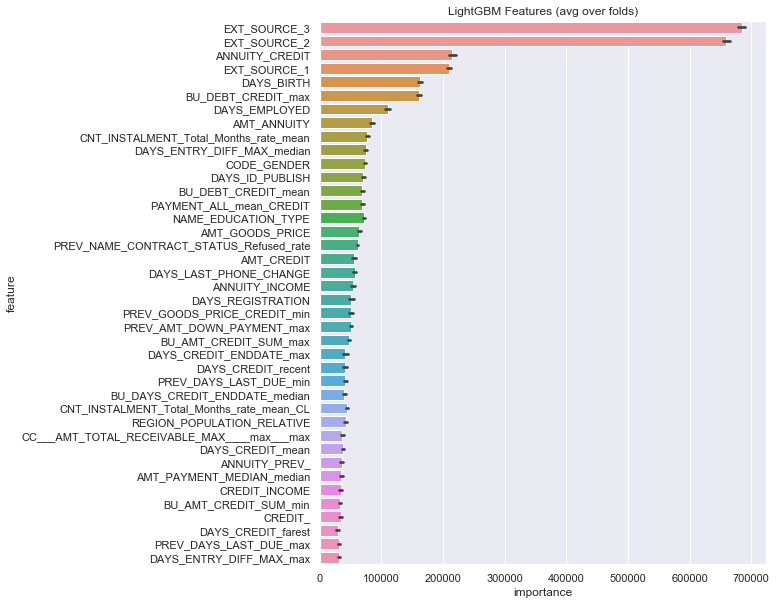

In [43]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

In [ ]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：gbdt

In [ ]:
# init_time = time.time()
# kfold_lightgbm(final_df, 10, boosting_type= 'gbdt')
# print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：dart

In [ ]:
# init_time = time.time()
# kfold_lightgbm(final_df,10, boosting_type= 'dart')
# print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：rf

In [ ]:
# init_time = time.time()
# kfold_lightgbm(final_df,10,boosting_type= 'rf')
# print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

# XGBoost 模型

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle

In [ ]:
def kfold_xgb(df, num_folds, stratified = True, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting XGBoost. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        #if n_fold == 0: # REmove for full K-fold run
        cuda.select_device(0)
        cuda.close()
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = XGBClassifier(learning_rate =0.01, 
                            n_estimators=5000, 
                            max_depth=4, 
                            min_child_weight=5,
#                             tree_method='gpu_hist',
                            subsample=0.8, 
                            colsample_bytree=0.8, 
                            objective= 'binary:logistic',
                            nthread=4,
                            scale_pos_weight=2.5,
                            seed=28,
                            reg_lambda = 1.2)
        
#         clf = pickle.load(open('test.pickle','rb'))
        
        cuda.select_device(0)
        cuda.close()
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        
        cuda.select_device(0)
        cuda.close()
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] # / folds.n_splits # - Uncomment for K-fold 

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

        np.save("xgb_oof_preds_1", oof_preds)
        np.save("xgb_sub_preds_1", sub_preds)
        
        cuda.select_device(0)
        cuda.close()
        
    
    clf = pickle.load(open('test.pickle','rb'))
    # print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_XGBoost_GPU.csv', index= False)
    #display_importances(feature_importance_df)
    #return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBoost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('xgb_importances02.png')

In [ ]:
init_time = time.time()
kfold_xgb(final_df, 5)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

---

Below not executed

## Balance the 'TARGET' column

In [ ]:
appl_all_processed_df['TARGET'].value_counts()

In [ ]:
balanceFactor = ((appl_all_processed_df['TARGET'].value_counts()[0])/(appl_all_processed_df['TARGET'].value_counts()[1])).round(0).astype(int)
balanceFactor
# appl_all_processed_df['TARGET'].value_counts()[0]
# appl_all_processed_df['TARGET'].value_counts()[1]

In [ ]:
default_df = appl_all_processed_df[appl_all_processed_df['TARGET']==1]
default_df.shape

In [ ]:
default_df_balanced = pd.concat( [default_df] * (balanceFactor - 1), sort=False, ignore_index=True )
default_df_balanced.shape

In [ ]:
appl_all_processed_df_balanced = pd.concat([appl_all_processed_df , default_df_balanced], sort=False, ignore_index=True)
appl_all_processed_df_balanced.shape

In [ ]:
(appl_all_processed_df_balanced['TARGET'].unique(),
(appl_all_processed_df_balanced['TARGET'].value_counts()[1], \
appl_all_processed_df_balanced['TARGET'].value_counts()[0], \
appl_all_processed_df_balanced['TARGET'].isnull().sum()))

In [ ]:
# Apply the following gc if memory is running slow
del appl_all_processed_df_balanced
gc.collect()

---

---

# Todo

Todo:
* cleaning:
    * num_df: normalize with z-score
* feature engineering:
    * make reciprocol, polynomial columns of the existing columns. 1/x, x^x.
    * multiplying each columns, two columns at a time.
    * asset items, income items, willingness(history + misc profile) items, loading(principle + interest) items
    * Integration from other tables?

https://ithelp.ithome.com.tw/articles/10202059
https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
https://www.kaggle.com/parasjindal96/how-to-normalize-dataframe-pandas
    

---

## EDA

### Quick check for numerical columns

In [ ]:
numcol = df['CNT_FAM_MEMBERS']

In [ ]:
numcol.describe(), \
numcol.isnull().sum(), \
numcol.size

In [ ]:
numcol.value_counts(sort=True), numcol.unique().size

In [ ]:
# numcol_toYear = pd.to_numeric(\
#                               ((numcol.abs() / 365) \
#                                .round(0)) \
#                               ,downcast='integer')
# numcol_toYear.describe()

In [ ]:
# numcol_toYear.value_counts(sort=True), numcol_toYear.unique().size

### Quick check for categorical columns

In [ ]:
catcol = df['HOUR_APPR_PROCESS_START']

In [ ]:
catcol.unique(), \
catcol.unique().size

In [ ]:
catcol.value_counts(sort=True)

In [ ]:
catcol.isnull().sum(), \
catcol.size

In [ ]:
catcol.isnull().sum(), \
catcol.size

## Appendix

### Tool: Getting summary dataframe

In [ ]:
# might not be very useful at this point
def summary_df (data_df):
    """ 
    Output: a new dataframe with summary info from the input dataframe.
    Input: data_df, the original dataframe
    """
    summary_df = pd.concat([(data_df.describe(include='all')), \
           (data_df.dtypes.to_frame(name='dtypes').T), \
           (data_df.isnull().sum().to_frame(name='isnull').T), \
           (data_df.apply(lambda x:x.unique().size).to_frame(name='uniqAll').T)])
    return summary_df

def data_quality_df (data_df):
    """ 
    Output: a new dataframe with summary info from the input dataframe.
    Input: data_df, the original dataframe
    """
    data_quality_df = pd.concat([(data_df.describe(include='all')), \
           (data_df.dtypes.to_frame(name='dtypes').T), \
           (data_df.isnull().sum().to_frame(name='isnull').T), \
           (data_df.apply(lambda x:x.unique().size).to_frame(name='uniqAll').T)])
    return data_quality_df.iloc[[11,13,12,0,],:]


In [ ]:
data_quality_df(appl_all_df)

In [ ]:
# df.to_csv(file_name, encoding='utf-8', index=False)
# data_quality_df(df).to_csv("./eda_output/application_train_data_quality.csv")

In [ ]:
df['CNT_CHILDREN'].value_counts()

In [ ]:
df['CNT_CHILDREN'].value_counts().sum()

In [ ]:
df.describe()

In [ ]:
summary_df(df)

In [ ]:
# df.to_csv(file_name, encoding='utf-8', index=False)
# summary_df(df).to_csv("./eda_output/application_train_summary_df.csv")

---

### .nunique() function

In [ ]:
# nunique() function excludes NaN 
# i.e. it does not consider NaN as a "value", therefore NaN is not counted as a "unique value"
df.nunique()

In [ ]:
df.nunique() == df.apply(lambda x:x.unique().shape[0])

In [ ]:
df['AMT_REQ_CREDIT_BUREAU_YEAR'].unique().shape[0]

In [ ]:
df['AMT_REQ_CREDIT_BUREAU_YEAR'].nunique()

In [ ]:
df['AMT_REQ_CREDIT_BUREAU_YEAR'].unique().size

### .value_counts() function

In [ ]:
# .value_counts() function has similar viewpoint towards NaN.
# i.e. it does not consider null as a value, therefore not counted in .value_counts()

In [ ]:
df['NAME_TYPE_SUITE'].value_counts()

In [ ]:
df['AMT_REQ_CREDIT_BUREAU_YEAR'].isnull().sum()

In [ ]:
df['AMT_REQ_CREDIT_BUREAU_YEAR'].size

In [ ]:
df['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts().sum() + df['AMT_REQ_CREDIT_BUREAU_YEAR'].isnull().sum() == \
df['AMT_REQ_CREDIT_BUREAU_YEAR'].size

### 重複值

In [ ]:
# Counting unique values (cf. .nunique() function, see above section)
# This code was retrieved from HT

df.apply(lambda x:x.unique().shape[0])

In [ ]:
# It is the same if you write (df.apply(lambda x:x.unique().size))
assert (df.apply(lambda x:x.unique().shape[0])==df.apply(lambda x:x.unique().size)).all

In [ ]:
# # %timeit showed the performances are similar
# %timeit df.apply(lambda x:x.unique().shape[0])
# %timeit df.apply(lambda x:x.unique().size)

### 空值

In [ ]:
# 含空值欄位占比
print(f"{df.isnull().any().sum()} in {df.shape[1]} columns (ratio: {(df.isnull().any().sum()/df.shape[1]).round(2)}) has empty value(s)")


---

## re-casting to reduce memory use (beta)

In [ ]:
# np.isfinite(num_df).all().value_counts()

In [ ]:
# num_df_finite = num_df[num_df.columns[np.isfinite(num_df).all()]]
# num_df_infinite = num_df[num_df.columns[np.isfinite(num_df).all() == False]]
# num_df_finite.shape, num_df_infinite.shape

In [ ]:
# assert num_df_finite.shape[0] == num_df_infinite.shape[0] == num_df.shape[0]
# assert num_df_finite.shape[1] + num_df_infinite.shape[1] == num_df.shape[1]

In [ ]:
# def reduce_mem_usage(props, finite:bool = True):
#     props.info(verbose=False)
#     start_mem_usg = props.memory_usage().sum() / 1024**2 
#     print("Memory usage of properties dataframe is :",start_mem_usg," MB")
#     if finite == True:  
#         props[props.columns[(props.min()>=0) & (props.max()<255)]] = \
#         props[props.columns[(props.min()>=0) & (props.max()<255)]].astype(np.uint8, copy=False)
#         props.info(verbose=False)

#         props[props.columns[(props.min()>=0) &(props.max() >= 255) & (props.max()<65535)]] = \
#         props[props.columns[(props.min()>=0) &(props.max() >= 255) & (props.max()<65535)]] \
#         .astype(np.uint16, copy=False)
#         props.info(verbose=False)

#         props[props.columns[(props.min()>=0) &(props.max() >= 65535) & (props.max()<4294967295)]] = \
#         props[props.columns[(props.min()>=0) &(props.max() >= 65535) & (props.max()<4294967295)]] \
#         .astype(np.uint32, copy=False)
#         props.info(verbose=False)

#         props[props.columns[(props.min()>=0) &(props.max() >= 4294967295)]] = \
#         props[props.columns[(props.min()>=0) &(props.max() >= 4294967295)]] \
#         .astype(np.uint64, copy=False)
#         props.info(verbose=False)
#     else:
#         props = props.astype(np.float32, copy=False)
#         props.info(verbose=False)
        
#     print("___MEMORY USAGE AFTER COMPLETION:___")
#     mem_usg = props.memory_usage().sum() / 1024**2 
#     print("Memory usage is: ",mem_usg," MB")
#     print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
#     return props

# if num_na_df_finite.min()>=0:
#     if num_na_df_finite.max() < 255:
#         props[col] = props[col].astype(np.uint8)
#     elif num_na_df_finite.max() < 65535:
#         props[col] = props[col].astype(np.uint16)
#     elif num_na_df_finite.max() < 4294967295:
#         props[col] = props[col].astype(np.uint32)
#     else:
#         props[col] = props[col].astype(np.uint64)

In [ ]:
# num_df_finite.info()

In [ ]:
# num_df_finite = reduce_mem_usage(num_df_finite, finite = True)

In [ ]:
# num_df_infinite.info()

In [ ]:
# num_df_infinite = reduce_mem_usage(num_df_infinite, finite = False)

In [ ]:
# num_df = pd.concat([num_df_finite, num_df_infinite], axis ='columns')
# num_df.info()

In [ ]:
# assert num_df_finite.shape[0] == num_df_infinite.shape[0] == num_df.shape[0]
# assert num_df_finite.shape[1] + num_df_infinite.shape[1] == num_df.shape[1]

In [ ]:
# del num_df_finite
# del num_df_infinite
# gc.collect()

THE END